# Propaganda Sequence Identification Project
## Identifying and classifying propaganda sequences in news articles using a custom deep learning pipeline based on token classification.

### Introduction
The increasing popularity of online news and social media has heightened the need to automatically detect propaganda in digital content. While much prior research focused primarily on document-level analysis, more granular approaches are necessary to identify specific instances of propaganda techniques within texts.
This project explores the application of transfer learning using DistilBERT to address two key challenges in propaganda detection: identifying text spans containing propaganda and classifying the specific propaganda technique employed. Building on the framework of SemEval-2020 Task 11, developed by Da San Martino et al. (2020), we leverage a dataset of news articles manually annotated by professional fact-checkers across 14 propaganda categories.
Our implementation fine-tunes the distilbert-base-uncased model for both span identification and technique classification tasks. This fine-grained approach enables detailed analysis of how propaganda manifests within news content, rather than merely flagging entire articles as propagandistic or not. Such capabilities could support journalists, fact-checkers, and researchers in studying media manipulation, while also helping readers critically evaluate their news sources.
The growing popularity of services like Ground News and projects like Tanbih highlights a rising public interest in understanding media bias. Tools capable of detecting and classifying specific propaganda techniques could provide valuable insights for consumers seeking to better understand the information landscape. This notebook demonstrates our methodology for implementing and evaluating transformer-based models to create such tools, which could add significant value for both media professionals and the general public.


![Screenshot 2024-12-22 at 20-42-58 .png](<attachment:Screenshot 2024-12-22 at 20-42-58 .png>)
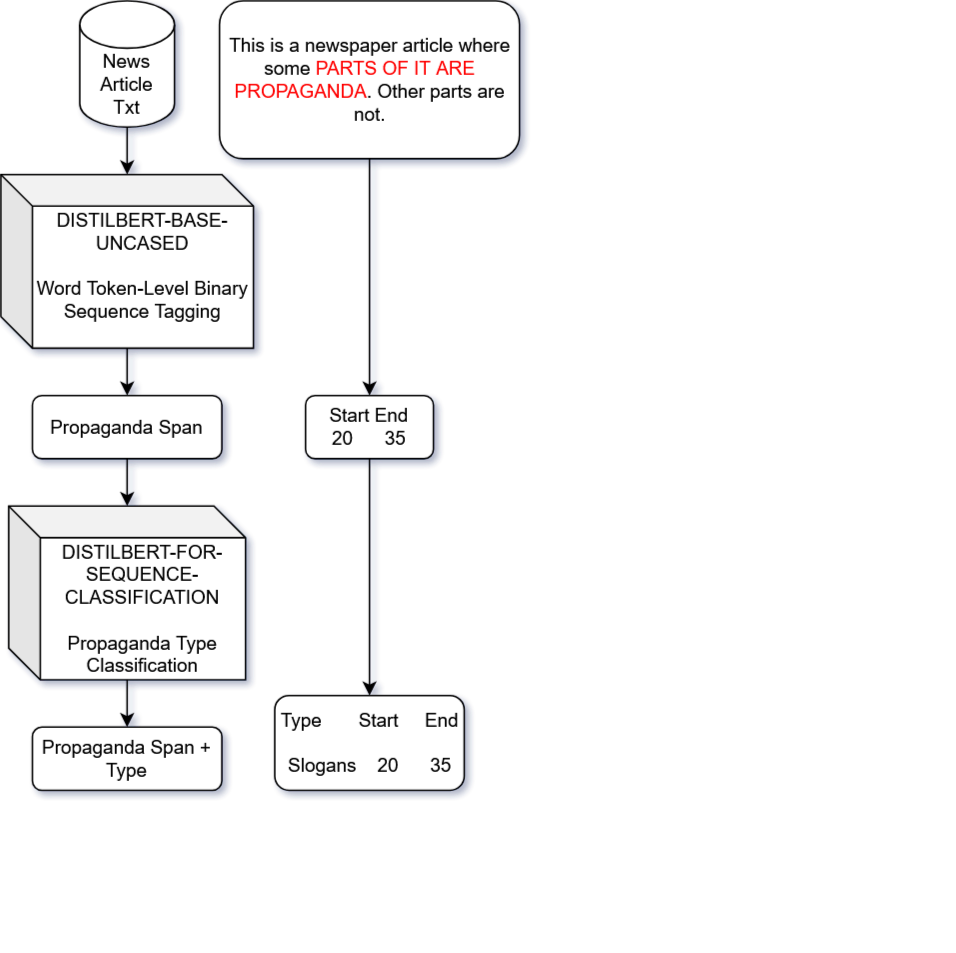

All imports necessary for the project. For CUDA it is necessary to use Python version 3.11.5.

In [4]:
import os
import torch
import numpy as np
from typing import Optional, Dict, Any, List, Tuple


from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments, 
    Trainer,
    DataCollatorForTokenClassification,
    EarlyStoppingCallback
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    classification_report
)


import pandas as pd
import glob
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, EvalPrediction
from torch.utils.data import Dataset

We create a class PropagandaDetector to access all the functions, models and paths and tokenizer necessary for Task 1.
To initialize, it receives a model name and an output directory where the trained models are stored. Both can be customized, we achieved the best performance with the distilbert-base-uncased model so that is chosen as a default. Additionally, the max_span_length sets the length for the tokenizer, in this case meaning that articles that are longer than 512 huggingface wordpiece tokens will only have the first 512 tokens evaluated for training and prediction, the rest is truncated. For our purposes this is enough, there were no articles in our dataset that exceeded this length, however this is something to be aware of when trying to evaluate longer articles. The class is designed to This pipeline was designed to preprocess news articles into tokenized input suitable for model training, train a deep learning model to classify text spans as propaganda or non-propaganda and evaluate the model using standard metrics like precision, recall, and F1-score.

Methods:
Data Preprocessing

Dataset Overview:
The dataset comprises news articles labeled with propaganda spans. These spans are annotated with start and end character indices, denoting propaganda regions. The preprocessing steps convert these indices into token-level labels compatible with the transformer model.

Key Preprocessing Steps:

    Extract Word Labels:
        Aligns propaganda spans with tokenized text.
        Ensures padding tokens are ignored during training.
    Load Dataset:
        Reads labeled data from directories, tokenizes text, and aligns spans with tokens.
        Utilizes Hugging Face’s Dataset object for efficient handling.

Model Configuration

The project employs distilBERT as the base model, fine-tuned for token classification.

Model Architecture:

    Token classification head with two labels: Propaganda and Non-Propaganda.
    Pre-trained embeddings from distilBERT for efficient and effective learning.

Training Pipeline:

    Early stopping with patience to prevent overfitting.
    Dynamic learning rate adjustment using ReduceLROnPlateau.
    Gradient accumulation for memory efficiency on large batches.

Metrics:

    Accuracy: Measures overall correctness.
    Precision & Recall: Evaluates the trade-off between false positives and false negatives.
    F1 Score: Balances precision and recall for binary classification.

Training Details

    Split Dataset:
        The dataset is split into training (90%) and validation (10%) sets.
    Optimizer:
        AdamW optimizer with an initial learning rate of 5e-5.
    Callback:
        Early stopping and learning rate scheduling for improved training dynamics.
    Batch Size:
        Adaptive batch size depending on hardware capabilities (e.g., CUDA availability).

In [5]:
class PropagandaDetector:
    def __init__(self, 
                 model_name: str = 'distilbert-base-uncased', 
                 output_dir: str = "propaganda_detector",
                 max_span_length: int = 512,
                 resume_from_checkpoint: Optional[str] = None):
        """
        Initialize the Propaganda Detector.
        
        Args:
            model_name (str): Base model to use
            output_dir (str): Directory to save model and outputs
            max_span_length (int): Maximum length of text spans
            resume_from_checkpoint (str, optional): Path to checkpoint to resume training
        """
        # Check if CUDA is available and set device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        print(f"CUDA Available: {torch.cuda.is_available()}")
        if torch.cuda.is_available():
            print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
            print(f"CUDA Device Capability: {torch.cuda.get_device_capability(0)}")

        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        self.max_span_length = max_span_length

        # Initialize tokenizer
        if resume_from_checkpoint:
            self.tokenizer = AutoTokenizer.from_pretrained(resume_from_checkpoint)
        else:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.tokenizer.pad_token_id = self.tokenizer.eos_token_id

        # Initialize or load model
        if resume_from_checkpoint:
            self.model = AutoModelForTokenClassification.from_pretrained(
                resume_from_checkpoint, num_labels=2
            )
        else:
            self.model = AutoModelForTokenClassification.from_pretrained(
                model_name, num_labels=2
            )
        
        self.model.resize_token_embeddings(len(self.tokenizer))
        self.model.config.pad_token_id = self.tokenizer.pad_token_id
        self.model.to(self.device)

    def extract_word_labels(self, text: str, propaganda_spans: List[Tuple[int, int]]) -> Dict[str, Any]:
        """
        Convert propaganda spans to word-level labels.

        Args:
            text (str): Full text content.
            propaganda_spans (List[Tuple[int, int]]): List of start and end indices for propaganda spans.

        Returns:
            A dictionary with tokenized `input_ids` and aligned `labels`.
        """
        # Tokenize the text
        tokenized = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_span_length,
            return_offsets_mapping=True  # Get offsets for alignment
        )

        # Initialize labels
        labels = [0] * len(tokenized["input_ids"])  # Default to non-propaganda (0)

        # Align spans with tokens
        for start, end in propaganda_spans:
            for idx, (token_start, token_end) in enumerate(tokenized["offset_mapping"]):
                if token_start >= start and token_end <= end:  # Token falls within a propaganda span
                    labels[idx] = 1  # Propaganda
        
        # Ensure padding tokens are ignored during training
        for idx, token_id in enumerate(tokenized["input_ids"]):
            if token_id == self.tokenizer.pad_token_id:
                labels[idx] = -100  # Ignore padding tokens during loss computation

        # Remove offset mapping (not needed for training)
        tokenized.pop("offset_mapping")

        # Add labels to tokenized data
        tokenized["labels"] = labels
        return tokenized


    def load_data(self, articles_dir: str, train_labels_dir: str) -> Dataset:
        """
        Loads articles and generates token-level labels from propaganda spans. 

        Args:
         articles_dir (str): Directory containing article files.
         train_labels_dir (str): Path to labels file.

        Returns:
            A HuggingFace Dataset object with tokenized input and aligned labels.
        """
        data = []

        # Read all label spans from the labels file
        article_labels = {}
        with open(train_labels_dir, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 3:
                    article_id, start, end = parts[0], int(parts[1]), int(parts[2])
                    if article_id not in article_labels:
                        article_labels[article_id] = []
                    article_labels[article_id].append((start, end))

        # Process each article
        for article_file in os.listdir(articles_dir):
            # Ensure the file matches the expected naming pattern
            if not article_file.startswith('article') or not article_file.endswith('.txt'):
                continue

            # Extract article ID
            article_id = article_file[7:-4]  # Remove 'article' prefix and '.txt' suffix
            article_path = os.path.join(articles_dir, article_file)

            # Read article text
            with open(article_path, 'r', encoding='utf-8') as f:
                text = f.read()

            # If there are labels for this article
            if article_id in article_labels:
                propaganda_spans = article_labels[article_id]
                tokenized_data = self.extract_word_labels(text, propaganda_spans)
                data.append(tokenized_data)

        if not data:
            raise ValueError("No data loaded. Check dataset paths.")

        # Return a HuggingFace Dataset
        return Dataset.from_list(data)


    def tokenize_data(self, examples):
        """
        Tokenizes a batch of examples.

        Args:
            examples (Dict[str, Any]): A dictionary of examples with keys 'text' and 'label'

        Returns:
            Tokenized examples ready for model training.
        """
        tokens = self.tokenizer(
             examples['text'], 
            truncation=True, 
            padding=True, 
            max_length=self.max_span_length
            )
        tokens["labels"] = examples["label"]
        return tokens

    def compute_metrics(self, eval_pred):
        """
        Compute metrics for the Hugging Face Trainer.

        Args:
            eval_pred: Named tuple containing predictions and labels.

        Returns:
            Dict[str, float]: Dictionary containing accuracy, precision, recall, F1 score, and class-specific metrics.
        """
        labels = eval_pred.label_ids
        preds = eval_pred.predictions.argmax(axis=-1)

        # Mask ignored tokens (-100)
        valid_indices = labels != -100
        labels_flat = labels[valid_indices]
        preds_flat = preds[valid_indices]

        # Compute overall metrics
        accuracy = accuracy_score(labels_flat, preds_flat)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels_flat, preds_flat, average="binary", zero_division=1
        )

        # Per-Class Metrics
        class_metrics = precision_recall_fscore_support(
            labels_flat, preds_flat, average=None, labels=[0, 1]
        )
        non_propaganda_metrics = {
            "precision": class_metrics[0][0], 
            "recall": class_metrics[1][0], 
            "f1": class_metrics[2][0]
        }
        propaganda_metrics = {
            "precision": class_metrics[0][1], 
            "recall": class_metrics[1][1], 
            "f1": class_metrics[2][1]
        }

        # Optional Debug Logging for a Subset
        if getattr(self, "output_dir", None):
            debug_path = os.path.join(self.output_dir, "debug_labels_preds.txt")
            sample_indices = np.random.choice(len(labels_flat), size=min(100, len(labels_flat)), replace=False)
            with open(debug_path, "w") as f:
                f.write("Subset of Predictions and True Labels:\n")
                for i in sample_indices:
                    f.write(f"Index: {i}, True Label: {labels_flat[i]}, Predicted Label: {preds_flat[i]}\n")

            # Classification report
            report = classification_report(
                labels_flat,
                preds_flat,
                target_names=["Non-Propaganda", "Propaganda"]
            )
            report_path = os.path.join(self.output_dir, "classification_report.txt")
            with open(report_path, "w") as f:
                f.write("Detailed Classification Report:\n")
                f.write(report)

        return {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "non_propaganda_metrics": non_propaganda_metrics,
            "propaganda_metrics": propaganda_metrics
        }

    def train(self, 
            train_articles_dir: str, 
            train_labels_dir: str, 
            test_size: float = 0.1,
            epochs: int = 1, 
            learning_rate: float = 5e-5,
            gradient_accumulation_steps: int = 2,
            lr_decay_patience: int = 5):
        """
        Train the propaganda detector using gradient accumulation.
        """
        # Load tokenized dataset
        tokenized_dataset = self.load_data(train_articles_dir, train_labels_dir)        
        train_test_split = tokenized_dataset.train_test_split(test_size=test_size)
        
        # Early stopping on plateau
        early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)  # Patience is the number of evaluations with no improvement

        # Training arguments with gradient accumulation
        training_args = TrainingArguments(
            output_dir=self.output_dir,
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=learning_rate,
            per_device_train_batch_size=64 if torch.cuda.is_available() else 16,
            per_device_eval_batch_size=64 if torch.cuda.is_available() else 16,
            auto_find_batch_size=True,
            num_train_epochs=epochs,
            weight_decay=0.01,
            gradient_accumulation_steps=gradient_accumulation_steps,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            logging_dir=os.path.join(self.output_dir, "logs"),
            logging_steps=10,
            save_total_limit=15,
            fp16=torch.cuda.is_available(),  # Mixed precision training
            dataloader_num_workers=4 if torch.cuda.is_available() else 0,
            max_grad_norm=1.0,
            callbacks=[early_stopping_callback]
        )

        # Data collator for efficient padding
        data_collator = DataCollatorForTokenClassification(
            tokenizer=self.tokenizer,
            padding=True,
            return_tensors="pt"
        )

        # Optimizer and scheduler
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=lr_decay_patience, verbose=True)

        # Function to update scheduler on evaluation
        def update_scheduler(trainer, state, control, metrics=None, **kwargs):
            if metrics and "eval_loss" in metrics:
                scheduler.step(metrics["eval_loss"])

        # Trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_test_split["train"],
            eval_dataset=train_test_split["test"],
            compute_metrics=self.compute_metrics,  # No changes here
            data_collator=data_collator,
            optimizers=(optimizer, None),  # Scheduler handled separately
            
        )

        # Train and evaluate
        trainer.train()
        trainer.evaluate()

        # Save final model and tokenizer
        trainer.save_model(os.path.join(self.output_dir, "final_model"))
        self.tokenizer.save_pretrained(os.path.join(self.output_dir, "final_model"))


    def predict(self, article_id: str, text: str) -> List[str]:
        """
        Predict propaganda spans in the given text.

        Args:
            article_id (str): The ID of the article.
            text (str): Input text to analyze.

        Returns:
            List[str]: Predictions in the format "article_id start end".
        """

        # Tokenize the input text
        tokenized = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_span_length,
            return_offsets_mapping=True,  # Get offsets for alignment
            return_tensors="pt"
        ).to(self.device)

        # Extract offset mapping and remove it from tokenized inputs
        offset_mapping = tokenized.pop("offset_mapping")

        # Make predictions
        with torch.no_grad():
            outputs = self.model(**tokenized)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)  # Keep as a tensor for consistency

        # Ensure predictions are a list (handles single vs batch cases)
        predictions = predictions.squeeze().tolist()
        if isinstance(predictions, int):  # Single prediction case
            predictions = [predictions]

        # Convert predictions back to text spans
        propaganda_spans = []
        offset_mapping = offset_mapping.squeeze().tolist()
        if isinstance(offset_mapping[0], int):  # Handle single-token case
            offset_mapping = [offset_mapping]

        for idx, pred in enumerate(predictions):
            if pred == 1:  # Predicted as propaganda
                start, end = offset_mapping[idx]
                propaganda_spans.append((start, end))
        
        # Merge consecutive spans
        merged_spans = []
        for start, end in propaganda_spans:
            if not merged_spans or start > merged_spans[-1][1]:
                merged_spans.append((start, end))
            else:
                # Extend the last span
                merged_spans[-1] = (merged_spans[-1][0], max(merged_spans[-1][1], end))


        # Format output as "article_id start end"
        formatted_output = [f"{article_id}\t{start}\t{end}" for start, end in merged_spans]

        return formatted_output

    def predict_from_folder(self, folder_path: str, output_file: str) -> None:
        """
        Predict propaganda spans for all articles in a folder and save the results.

        Args:
            folder_path (str): Path to the folder containing test article `.txt` files.
            output_file (str): Path to the file where predictions will be saved.

        Returns:
            None: Writes predictions to the specified output file.
        """
        all_predictions = []

        # Process each article file in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.txt') and file_name.startswith('article'):
                # Extract article ID from the file name
                article_id = file_name[7:-4]  # Removes 'article' prefix and '.txt' suffix
                file_path = os.path.join(folder_path, file_name)

                # Read the article text
                with open(file_path, 'r', encoding='utf-8') as file:
                    text = file.read()

                # Get predictions for this article
                predictions = self.predict(article_id, text)
                
                # Concatenate continuous spans
                merged_predictions = []
                current_start, current_end = None, None
                for prediction in predictions:
                    _, start, end = prediction.split('\t')
                    start, end = int(start), int(end)

                    if current_start is None:
                        current_start, current_end = start, end
                    elif start <= current_end + 1:  # Extend the current span
                        current_end = max(current_end, end)
                    else:  # Save the completed span
                        merged_predictions.append(f"{article_id}\t{current_start}\t{current_end}")
                        current_start, current_end = start, end

                # Save the last span
                if current_start is not None:
                    merged_predictions.append(f"{article_id}\t{current_start}\t{current_end}")

                all_predictions.extend(merged_predictions)

        # Insert "?" as the second column for the propaganda type, necessary for pipeline into the second model
        all_predictions = [line.split('\t')[0] + '\t?\t' + '\t'.join(line.split('\t')[1:]) for line in all_predictions]

        # Save all predictions to the output file
        with open(output_file, "w") as f:
            for line in all_predictions:
                f.write(line + "\n")

        print(f"Predictions saved to {output_file}")

    def save_predictions(self, output_file: str, predictions: List[str]):
        """
        Save predictions to a file.

        Args:
            output_file (str): Path to the output file.
            predictions (List[str]): List of predictions in the format "article_id start end".
        """
        with open(output_file, "w") as f:
            f.write("\n".join(predictions) + "\n")


            

# We used this function during development for debugging to fix misalignment of tokens and labels between prediction and training

def test_tokenization_and_label_alignment_for_article(detector: PropagandaDetector, article_path: str, labels_path: str):
    """
    Test if tokenization and label alignment during training match tokenization during inference
    for a specific article.

    Args:
        detector (PropagandaDetector): The initialized detector instance.
        article_path (str): Path to the article file.
        labels_path (str): Path to the corresponding labels file.
    """
    # Read the article content
    with open(article_path, 'r', encoding='utf-8') as f:
        text = f.read()

    # Read the labels for the article
    article_id = article_path.split('/')[-1].split('.')[0].replace('article', '')
    spans = []
    with open(labels_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if parts[0] == article_id:
                spans.append((int(parts[1]), int(parts[2])))

    print(f"Article ID: {article_id}")
    print(f"Text length: {len(text)}")
    print(f"Propaganda spans: {spans}")

    # Tokenization and label alignment
    training_tokenized = detector.extract_word_labels(text, spans)
    print("\n=== Training Tokenization & Labels ===")
    for token_id, label in zip(training_tokenized["input_ids"], training_tokenized["labels"]):
        print(f"Token ID: {token_id}, Token: {detector.tokenizer.decode([token_id])}, Label: {label}")

    # Inference tokenization
    inference_tokenized = detector.tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=detector.max_span_length,
        return_offsets_mapping=True,
        return_tensors="pt"
    )
    offsets = inference_tokenized.pop("offset_mapping").squeeze().tolist()

    print("\n=== Inference Tokenization ===")
    for token_id, offset in zip(inference_tokenized["input_ids"].squeeze().tolist(), offsets):
        token = detector.tokenizer.decode([token_id])
        print(f"Token ID: {token_id}, Token: {token}, Offset: {offset}")

    print("\n=== Comparison of Training and Inference ===")
    for idx, (train_id, train_label) in enumerate(zip(training_tokenized["input_ids"], training_tokenized["labels"])):
        if idx < len(inference_tokenized["input_ids"].squeeze()):
            infer_id = inference_tokenized["input_ids"].squeeze()[idx].item()
            if train_id != infer_id:
                print(f"Mismatch at index {idx}: Training Token ID {train_id}, Inference Token ID {infer_id}")
            else:
                print(f"Match at index {idx}: Token ID {train_id}")
        else:
            print(f"Training token {train_id} exceeds inference tokenization length.")

    print("\n=== Debugging Completed ===")

Results and Analyses
Model Performance

The model was evaluated using a validation set, with the following metrics reported:

    Precision: 37.95%
    Recall: 42.20%
    F1 Score: 39.96%

These metrics demonstrate the model's capability to accurately identify propaganda spans in textual data, getting close to the competition winner's F1-score of around 0.5.

Using the PropagandaDetector class to load our pretrained DISTILBERT-BASE-UNCASED model from a checkpoint and create predictions of propaganda spans on the test articles.

In [6]:
# Set up Model from checkpoint/new model 
detector = PropagandaDetector(
    #model_name="distilbert-base-uncased",                      #select new model to use
    resume_from_checkpoint="models/output/final_model_monday",  #or select from which checkpoint to resume training/predictions
    max_span_length=512
)

# Paths to train and test articles and labels
test_articles_dir = 'datasets/test-articles'
train_articles_dir = 'datasets/train-articles'
test_labels_dir = 'datasets/test-task-tc-template.txt'

# Paths for testing on only two articles
subset_train_articles_dir = 'datasets/two-articles'
subset_train_labels_dir = 'datasets/two-labels'

output_predictions_file = "predictions.txt"

# Create predictions on all articles in the test_articles_dir path folder, store predictions in output_predictions_file
detector.predict_from_folder(test_articles_dir, output_predictions_file)

Using device: cpu
CUDA Available: False
Predictions saved to predictions.txt


Alternatively, a new model can be trained from scratch.

TODO: @Conrad add your code that you used to train our model for task 1

In [ ]:
detector = PropagandaDetector(
    model_name="distilbert-base-uncased",                      #customize model_name to choose a different huggingface model
    max_span_length=512
)

The predictions of the binary sequence tagging task performed above in combination with the original article texts are used as an input for the second task: Classifying the detected propaganda spans into their respective propaganda types.

### Task 2: Propaganda Type Classification

All relevant libraries have been imported above.

First, we define the 14 classes. Because some classes were combined they contain several (similar) types of propaganda: 2, 5, 12, 14

In [ ]:
# Define the label-to-ID mapping
label_to_id = {
    "O": 0,  # Background or no-propaganda
    "Loaded_Language": 1,
    "Name_Calling,Labeling": 2,
    "Repetition": 3,
    "Doubt": 4,
    "Exaggeration,Minimisation": 5,
    "Appeal_to_Authority": 6,
    "Black-and-White_Fallacy": 7,
    "Causal_Oversimplification": 8,
    "Slogans": 9,
    "Appeal_to_Fear-Prejudice": 10,
    "Flag-Waving": 11,
    "Whataboutism,Straw_Men,Red_Herring": 12,
    "Thought-Terminating_Cliches": 13,
    "Bandwagon,Reductio_ad_hitlerum": 14
}

load_training_data loads and structures training data from text articles and their associated label files. The function consolidates article text and annotated propaganda spans into a dictionary format keyed by article IDs and containing start, end, and label (propaganda type) suitable for further processing by the extract_span_texts_and_labels function below.

In [ ]:
def load_training_data(train_articles_dir: str, train_labels_dir: str):
    """
    Loads the training articles and their associated propaganda spans.

    Parameters
    ----------
    train_articles_dir : str
        Path to the directory containing the training article text files.
    train_labels_dir : str
        Path to the directory containing the label files.
        
    Returns
    -------
    dict
        A dictionary keyed by article ID, each value is a dictionary containing:
        {
            "text": str,  # full article text
            "spans": [
                {
                    "label": str,        # propaganda type
                    "start": int,        # start index of span
                    "end": int           # end index of span
                },
                ...
            ]
        }
    """

    # Dictionary to hold loaded data
    data = {}

    # The articles follow a pattern like "article<id>.txt"
    article_files = glob.glob(os.path.join(train_articles_dir, "article*.txt"))

    for article_path in article_files:
        # Extract the article ID from the filename
        basename = os.path.basename(article_path)
        # Example filename: article111111111.txt -> article ID: 111111111
        article_id = basename.replace("article", "").replace(".txt", "")

        # Load the article text
        with open(article_path, "r", encoding="utf-8") as f:
            article_text = f.read()

        # Initialize the structure in the dictionary
        data[article_id] = {
            "text": article_text,
            "spans": []
        }

        # Corresponding label file should be: article<articleid>.task2-TC.labels
        label_file = os.path.join(train_labels_dir, f"article{article_id}.task2-TC.labels")

        if os.path.exists(label_file):
            with open(label_file, "r", encoding="utf-8") as lf:
                for line in lf:
                    line = line.strip()
                    if not line:
                        continue
                    # Each line format: articleid  label  start  end
                    parts = line.split('\t')
                    if len(parts) != 4:
                        continue
                    _, label, start_str, end_str = parts
                    start = int(start_str)
                    end = int(end_str)
                    
                    data[article_id]["spans"].append({
                        "label": label,
                        "start": start,
                        "end": end
                    })
        else:
            # If there's no label file, continue (some articles may not have propaganda spans)
            pass

    return data

extract_span_texts_and_labels processes the dictionary of training data returned by load_training_data. The function extracts propaganda spans and their corresponding labels, preparing the data for training by returning separate lists for span texts and associated labels. Unlike in task 1, only those sections labelled as containing a specific type of propaganda are retained. The function skips articles without spans and handles scenarios with overlapping spans.

In [ ]:
def extract_span_texts_and_labels(training_data):
    """
    Given a dictionary of training data as returned by load_training_data,
    extract the propaganda span texts and their corresponding labels.

    Parameters
    ----------
    training_data : dict
        Dictionary keyed by article ID, where each value is a dictionary:
        {
            "text": str (full article text),
            "spans": [
                {
                    "label": str,   # propaganda type
                    "start": int,   # start index of span in chars
                    "end": int      # end index of span in chars
                },
                ...
            ]
        }

    Returns
    -------
    span_texts : list of str
        A list of extracted span texts from the articles.
    span_labels : list of str
        A list of corresponding labels for each extracted span text.
    """
    span_texts = []
    span_labels = []
    
    print("=== DEBUG: Step 2 - Extracting Spans and Labels ===")
    for article_id, content in training_data.items():
        article_text = content["text"]
        spans = content["spans"]
        print(f"\nArticle ID: {article_id}")
        print(f"Article text length: {len(article_text)} chars")
        print(f"Number of spans found: {len(spans)}")
        
        for i, span in enumerate(spans):
            start = span["start"]
            end = span["end"]
            label = span["label"]
            span_text = article_text[start:end]
            span_texts.append(span_text)
            span_labels.append(label)

            # Print a few example spans for debugging
            if i < 3:
                print(f"  Example span {i+1}: '{span_text[:50]}...', Label: {label}, Start: {start}, End: {end}")

    print("\nTotal extracted spans:", len(span_texts))
    if len(span_texts) > 0:
        print("First 3 extracted spans:", span_texts[:3])
        print("First 3 extracted labels:", span_labels[:3])

    return span_texts, span_labels

predict applies a trained model to classify propaganda types for text spans within articles. It processes inputs from an article folder and a span file, loading and associating article text with specified spans (such as those found by the first model). The function tokenizes each span, performs inference using the fine-tuned DistilBERT model, and outputs predictions in a standardized format. It manages missing articles, filters invalid span data, and utilizes GPU acceleration for efficiency. Predictions are saved to an output file for evaluation.

In [ ]:
def predict(article_folder: str, span_file: str, model_path: str, output_file: str):
    """
    Predicts propaganda types for spans in articles using a trained model.

    Parameters
    ----------
    article_folder : str
        Path to the folder containing article text files.
    span_file : str
        Path to the file containing spans to predict in the format:
        <article_id>    <irrelevant_column>    <start>    <end>
    model_path : str
        Path to the trained model for prediction.
    output_file : str
        Path to save the predictions in the format:
        <article_id>    <start>    <end>    <predicted_label>
    """
    # Load the tokenizer and model
    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
    model = DistilBertForSequenceClassification.from_pretrained(model_path)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    # Load articles
    print("Loading articles...")
    articles = {}
    for file in os.listdir(article_folder):
        if file.startswith("article") and file.endswith(".txt"):
            article_id = file.replace("article", "").replace(".txt", "")
            with open(os.path.join(article_folder, file), "r", encoding="utf-8") as f:
                articles[article_id] = f.read()

    print(f"Loaded {len(articles)} articles.")

    # Load spans
    print("Loading spans...")
    spans = []
    with open(span_file, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 4:  # Ensure there are at least 4 columns
                article_id, _, start, end = parts
                spans.append((article_id, int(start), int(end)))
            else:
                print(f"Skipping invalid line: {line.strip()}")

    print(f"Loaded {len(spans)} spans.")

    # Predict propaganda type for each span
    print("Predicting propaganda types...")
    predictions = []
    for article_id, start, end in spans:
        if article_id in articles:
            article_text = articles[article_id]
            span_text = article_text[start:end]

            # Tokenize the span
            inputs = tokenizer(span_text, return_tensors="pt", truncation=True, padding=True, max_length=128)
            inputs = {key: val.to(device) for key, val in inputs.items()}

            # Get model predictions
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                predicted_label_id = torch.argmax(logits, dim=-1).item()
                predicted_label = model.config.id2label[predicted_label_id]

            # Save the prediction
            predictions.append((article_id, start, end, predicted_label))
        else:
            print(f"Warning: Article ID {article_id} not found.")

    # Save predictions to output file
    print(f"Saving predictions to {output_file}...")
    with open(output_file, "w", encoding="utf-8") as f:
        for article_id, start, end, predicted_label in predictions:
            f.write(f"{article_id}\t{start}\t{end}\t{predicted_label}\n")

    print("Predictions saved successfully.")

compute_metrics evaluates model performance by calculating accuracy, precision, recall, and F1-score. It processes predictions and ground-truth labels from EvalPrediction, extracting predicted classes by selecting the highest-scoring logits. Metrics are computed using macro averaging to ensure equal weighting of all classes, regardless of class imbalance. The function returns a dictionary mapping metric names to their respective values, for evaluation during training and testing.

In [ ]:
def compute_metrics(p: EvalPrediction):
    """
    Computes metrics for evaluation during training and testing.

    Parameters
    ----------
    p : EvalPrediction
        Contains `predictions` and `label_ids`:
        - `predictions` is a 2D array of shape (n_samples, n_classes) with the logits or probabilities.
        - `label_ids` is a 1D array of shape (n_samples,) with the ground-truth labels.

    Returns
    -------
    dict
        A dictionary mapping metric names to their values.
    """
    preds = p.predictions
    if isinstance(preds, tuple):
        preds = preds[0]
    # Get the predicted class by choosing the class with the highest logit score
    preds = preds.argmax(axis=1)
    labels = p.label_ids
    
    # Compute accuracy
    accuracy = accuracy_score(labels, preds)

    # Compute precision, recall, f1 for each class
    # average='macro' calculates metrics independently for each class 
    # and then takes the average of them
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=1)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

The following code prepares data and resources for training a propaganda classification model using DistilBERT. It verifies GPU availability, the training and testing data paths are redefined (in case different data is used than for task 1), and a subset option is provided for debugging or testing on a smaller dataset.

Articles and labels are loaded using load_training_data. Then, propaganda spans and their labels are extracted, forming the basis for model inputs. The class labels are mapped to integers for compatibility with the transformers library. 

In [ ]:
# Verify CUDA availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Paths to train and test articles and labels folders
test_articles_dir = 'datasets/test-articles'
train_articles_dir = 'datasets/train-articles'
test_labels_dir = 'datasets/test-task-tc-template.txt'
train_labels_dir = 'datasets/train-labels-task2-technique-classification'

# Paths for testing on only two articles
subset_train_articles_dir = 'datasets/two-articles'
subset_train_labels_dir = 'datasets/two-labels-task2'
output_predictions_file = "predictions_task2.txt"

testrundata = load_training_data(train_articles_dir, train_labels_dir)
span_texts, span_labels = extract_span_texts_and_labels(testrundata)

# Create a label map
unique_labels = sorted(set(span_labels))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

# Convert labels to integers
numeric_labels = [label2id[l] for l in span_labels]

# Tokenize the data
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
encodings = tokenizer(span_texts, truncation=True, padding=True, max_length=512)

# Create a Torch Dataset
class PropagandaTypeDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

dataset = PropagandaTypeDataset(encodings, numeric_labels)

# Split into train/validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
# Load a pretrained model
model = DistilBertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to(device)
    
# Early stopping on plateau
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=10)  # Patience is the number of evaluations with no improvement

# Define TrainingArguments and Trainer
training_args = TrainingArguments(
    output_dir='./results-task2',          # output directory
    num_train_epochs=100,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.02,               # strength of weight decay
    eval_strategy="epoch",              # evaluate at the end of each epoch
    save_strategy="epoch",
    logging_dir='./logs-task2',            # directory for storing logs
    logging_steps=50,
    save_total_limit=50,              # only keep last two checkpoints
    load_best_model_at_end=True,      # load best model at end of training
    report_to="none",                # disable reporting to wandb or similar
    use_cpu=False,                  # Use CUDA if available
    gradient_accumulation_steps=3,
    metric_for_best_model="f1",
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

# Uncomment to train the model
#trainer.train()

# Evaluate the model (trainer.evaluate returns metrics)
eval_metrics = trainer.evaluate()
print("Evaluation metrics:", eval_metrics)

# Save the fine-tuned model
trainer.save_model("./trained_model_task2")
tokenizer.save_pretrained("./trained_model_task2")

task2labelspath = 'datasets/train-task2-TC.labels'
predict(train_articles_dir, task2labelspath, model_name, output_predictions_file)

### Conclusion / Discussion

Our project demonstrates that transformer-based models can effectively detect and classify propaganda in news articles, though significant challenges remain. We experimented with different models from the RoBERTa, LLaMA, and BERT families, and ended up using DistilBERT because of the limited available computational resources. We achieved an F1 score of 0.40 for task 1 span identification and 0.53 for task 2 propaganda technique classification, aligning with average scores of previously reported ranges in the literature of 0.18-0.50 and 0.20-0.60, respectively (Da San Martino et al., 2020).

The results are particularly noteworthy given our use of a smaller model (DistilBERT, 66M parameters) compared to previous work that employed larger models like the BERT base model (110M), XLNet (340M), or XLM RoBERTa (355M), usually used in an ensemble method. This suggests that even resource-efficient approaches can achieve competitive performance in propaganda detection tasks and classification tasks.
The complexity of propaganda detection stems from several factors. Unlike simpler text classification tasks, identifying propagandistic content requires understanding context and recognizing author intent. Additionally, propaganda techniques vary widely, from simple loaded language to complex logical fallacies, making their automated detection particularly challenging.

While our model performs adequately on English-language news articles from 2017-2019, its generalizability to more recent content remains untested. Several opportunities exist for improving performance:

First, implementing more modern models like ModernBERT (released on 19/12/2024) or larger models like llama 3.1 could enhance detection accuracy. Second, expanding the training dataset with more recent news articles would help the model stay current with evolving propaganda techniques and language patterns. Finally, following the example of projects like Tanbih, incorporating zero-shot classification capabilities and multi-language support would increase the model's utility.

### Division of Labour:

Conrad: Data loading (minority), metrics, training setup, CUDA, hyperparameter tuning, poster making, elevator pitch, Introduction, Conclusion/Discussion

### Use of AI

The code was written by us. ChatGPT and Claude were used as debuggers and to create the docstrings.

### Sources

Jurkiewicz, D., Borchmann, Ł., Kosmala, I., & Graliński, F. (2020). ApplicaAI at SemEval-2020 task 11: On RoBERTa-CRF, span CLS and whether self-training helps them. arXiv preprint arXiv:2005.07934.

Martino, G., Barrón-Cedeno, A., Wachsmuth, H., Petrov, R., & Nakov, P. (2020). SemEval-2020 task 11: Detection of propaganda techniques in news articles. arXiv preprint arXiv:2009.02696.

https://huggingface.co/distilbert/distilbert-base-uncased

https://ground.news/

https://tanbih.qcri.org/publications/

